In [9]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import datasets, models, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader
from torch import optim
import torchvision.utils as vutils



# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sample_dir = 'result_face'
batch_size = 128
# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64
# Number of channels in the training images. For color images this is 3
nc = 3
# Size of z latent vector (i.e. size of generator input)
nz = 100
# Size of feature maps in generator
ngf = 64
# Size of feature maps in discriminator
ndf = 64
# Number of training epochs
num_epochs = 1000
# Learning rate for optimizers
lr = 0.0002
# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Image processing
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize((64, 64)),
                transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
                                     std=(0.5, 0.5, 0.5))])
# transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
#                                      std=[0.5])])

# Van Gogh paints dataset

data_dir = 'SCUT-FBP5500_v2'
data_VGP = datasets.ImageFolder(root = data_dir,
                                          transform = transform)

print(data_VGP)
# Data loader , drop_last=True means I do not want to use the last batch
data_loader = torch.utils.data.DataLoader(dataset=data_VGP, batch_size=batch_size, shuffle=True, drop_last=True)


Dataset ImageFolder
    Number of datapoints: 5500
    Root location: SCUT-FBP5500_v2
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [10]:
class Generator(nn.Module):
    def __init__(self, ngpu=1, nz=100, ngf=128, nc=3):
        super(Generator, self).__init__()
        '''
        self.ngpu : train gpu num
        nz  :  Size of z latent vector (i.e. size of generator input)
        ngf :  Size of feature maps in generator
        nc  :  Number of channels in the generator images. For color images this is 3
        '''
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )
 
    def forward(self, input):
        return self.main(input)
 
 
 
 
class Discriminator(nn.Module):
    def __init__(self, ngpu, nc=3, ndf=16):
        super(Discriminator, self).__init__()
        '''
        ngpu: train gpu num
        nc  : Number of channels in the real images. For color images this is 3
        ndf : Size of feature maps in discriminator 
        '''
        self.ngpu = ngpu
        # Generator Code
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
 
    def forward(self, input):
        return self.main(input)
 
 
 
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# 1. load real image
print(len(data_VGP))
dataloader = DataLoader(data_VGP, batch_size=batch_size, shuffle=True)
print(len(dataloader))
print(dataloader)
 
 
# 2. load generator and discriminator
netG = Generator(ngpu=ngpu, nz=nz, ngf=ngf).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))
netG.apply(weights_init)   #  to ``mean=0``, ``stdev=0.02``.
print(netG)
 
 
# Create the Discriminator
netD = Discriminator(ngpu).to(device)
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))
netD.apply(weights_init)   # `to mean=0, stdev=0.2``.
print(netD)
 
# 3. loss function
criterion = nn.BCELoss()
 
# 4. Create batch of latent vectors that we will use to visualize
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
 
real_label = 1.
fake_label = 0.
 
# 5. Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr/2, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))
 
 
# 6. train loop
img_list = []
G_losses = []
D_losses = []
iters = 0
 
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, (data, _) in enumerate(dataloader):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        #print("label ",label.shape)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
 
        ## Train with all-fake batch
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)  
        #print("output ",output.shape)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
 
        errD = errD_real + errD_fake
        optimizerD.step()
 
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
 
        # Output training stats
        if i % 100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
 
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
 
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
 
                img_batch = vutils.make_grid(fake[:64], padding=2, normalize=False)
                img_batch = np.transpose(img_batch, (1,2,0)).numpy()
                img_batch = img_batch[:,:,:] * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
 
                plt.figure(figsize=(8,8))
                plt.axis("off")
                plt.title("Generate Images")
                plt.imshow(img_batch)
                model_path = "result_face/"+str(iters)
                if not os.path.exists(model_path):
                    os.makedirs(model_path)
                plt.savefig(model_path+"/fake.png")
                torch.save(netG.state_dict(), model_path+"/model.pth")
            # img_list.append(vutils.make_grid(fake[:64], padding=2, normalize=True))
 
        iters += 1
 
print("End Training Loop...")
x = range(iters)
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.xlabel("iters")
plt.ylabel("loss value")
plt.plot(x, D_losses,'-',label="D_loss", color='r')
plt.plot(x, G_losses,'-',label="G_loss", color='b')
plt.legend()
plt.grid(True)
plt.savefig("loss.png")

End Training Loop...


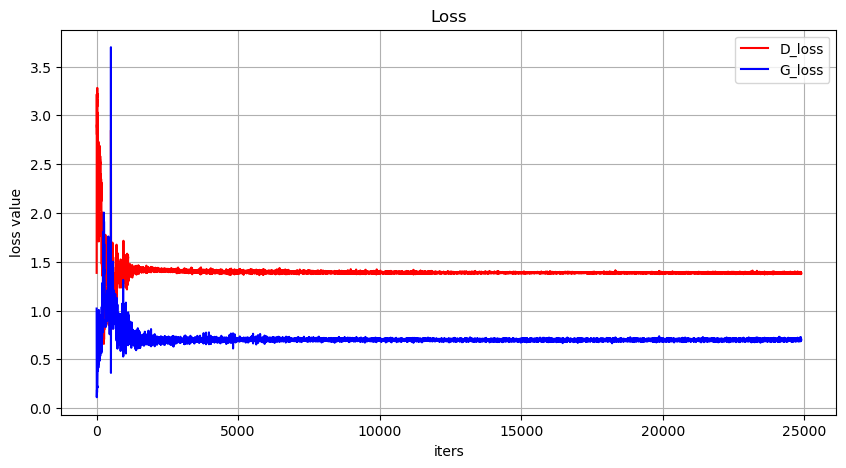

In [13]:
print("End Training Loop...")
x = range(iters)
plt.figure(figsize=(10,5))
plt.title("Loss")
plt.xlabel("iters")
plt.ylabel("loss value")
plt.plot(x, D_losses,'-',label="D_loss", color='r')
plt.plot(x, G_losses,'-',label="G_loss", color='b')
plt.legend()
plt.grid(True)
plt.savefig("loss.png")